In [32]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

import sys
sys.path.insert(1, "../scripts")
from ml_processors import ML_Processor as MLP

mlp = MLP()


In [2]:
cm_data =  pd.read_csv('../data/chrome_data.csv')
cm_w_data =  pd.read_csv('../data/chrome_mobile_webview_data.csv')
fb_data =  pd.read_csv('../data/facebook_data.csv')
pl_5_data =  pd.read_csv('../data/platform_5.csv')
pl_6_data =  pd.read_csv('../data/platform_6.csv')


In [3]:
pl_5_data.head(2)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,23b2028c-72ed-43b3-a2d7-d772b2d4d478,exposed,2020-07-03,8,iPhone,5,Mobile Safari,0,1
1,54a62f37-0c4d-4300-a063-1c6aa99244e5,control,2020-07-03,15,iPhone,5,Mobile Safari,0,1


In [4]:
columns_to_be_dropped = ['no','SAID_YES']
cm_data_clean = cm_data.drop(columns_to_be_dropped,axis=1)
cm_w_data_clean = cm_w_data.drop(columns_to_be_dropped,axis=1)
fb_data_clean = fb_data.drop(columns_to_be_dropped,axis=1)
pl_5_data_clean =pl_5_data.drop(columns_to_be_dropped[0],axis=1)
pl_6_data_clean = pl_6_data.drop(columns_to_be_dropped[0],axis=1)


In [5]:
cat, num = mlp.sep_cat_num(cm_data_clean)
print("Numerical Columns:", cat)
print("****************")
print("Categorical Columns:", num)

Numerical Columns: ['auction_id', 'experiment', 'date', 'device_make', 'browser']
****************
Categorical Columns: ['hour', 'yes']


In [6]:
cm_data_clean[cat].describe()

,auction_id,experiment,date,device_make,browser
count,695,695,695,695,695
unique,695,2,8,14,1
top,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-03,Generic Smartphone,Chrome Mobile
freq,1,371,176,665,695


In [7]:
pipe_1 = Pipeline(
    steps=[
        ("label categories", FunctionTransformer(mlp.cat_labeler, kw_args={"cat_cols": cat})),
        ("scale data", FunctionTransformer(mlp.scaler)),
        ("separate target and features", FunctionTransformer(mlp.target_feature, kw_args={"f_r": [0, 6], "t":-1})),
        ("divide dataset", FunctionTransformer(mlp.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8})),      
        ])
chrome_set = pipe_1.fit_transform(cm_data_clean)
chrome_mobile_set = pipe_1.fit_transform(cm_w_data_clean)
facebook_set = pipe_1.fit_transform(fb_data_clean)
platform_5_set = pipe_1.fit_transform(pl_5_data_clean)
platform_6_set = pipe_1.fit_transform(pl_6_data_clean)

cat_labeler output...

   auction_id  experiment  date  hour  device_make  browser  yes
0           0           1     1    16            1        0    1
1           1           1     3     8            1        0    0


scaler output... 

   auction_id  experiment      date      hour  device_make  browser  yes
0    0.000000         1.0  0.142857  0.695652     0.076923      0.0  1.0
1    0.001441         1.0  0.428571  0.347826     0.076923      0.0  0.0


target_features output... 

features size: (695, 6)


set_splitter output... 

X_train shape: (512, 6)
y_train shape: (512,)
x_test shape: (70, 6)
y_test shape: (70,)
X_val shape: (113, 6)
y_val shape: (113,)
cat_labeler output...

   auction_id  experiment  date  hour  device_make  browser  yes
0           0           1     2     2            3        0    0
1           1           1     2     6           11        0    0


scaler output... 

   auction_id  experiment      date      hour  device_make  browser  yes
0    0.000000      

In [8]:
cm_data_clean.head(2)

,auction_id,experiment,date,hour,device_make,browser,yes
0,0.000000,1.0,0.142857,0.695652,0.076923,0.0,1.0
1,0.001441,1.0,0.428571,0.347826,0.076923,0.0,0.0


In [9]:
pipe_chrome =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])
pipe_chrome_webview =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])
pipe_facebook =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])
pipe_pl_5 =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])
pipe_pl_6 =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])

In [10]:

chrome_model = pipe_chrome.fit(chrome_mobile_set[0], chrome_mobile_set[1])
result = pipe_chrome.score(chrome_mobile_set[4],chrome_mobile_set[5])

print(f'The accuracy we get using the chrome mobile webview data is: {result}')

The accuracy we get using the chrome mobile webview data is: 0.4864864864864865


In [11]:
pipe_chrome_webview.fit(chrome_set[0], chrome_set[1])
result = pipe_chrome_webview.score(chrome_set[4],chrome_set[5])

print(f'The accuracy we get using the chrome mobile data is: {result}')

The accuracy we get using the chrome mobile data is: 0.5663716814159292


In [12]:
pipe_facebook.fit(facebook_set[0], facebook_set[1])
result = pipe_facebook.score(facebook_set[4],facebook_set[5])

print(f'The accuracy we get using the facebook data is: {result}')

The accuracy we get using the facebook data is: 0.46153846153846156


In [13]:
pipe_pl_5.fit(platform_5_set[0], platform_5_set[1])
result = pipe_pl_5.score(platform_5_set[4],platform_5_set[5])

print(f'The accuracy we get using the platform 5 data is: {result}')

The accuracy we get using the platform 5 data is: 0.3333333333333333


In [14]:
pipe_pl_6.fit(platform_6_set[0], platform_6_set[1])
result = pipe_pl_6.score(platform_6_set[4],platform_6_set[5])

print(f'The accuracy we get using the platform 6 data is: {result}')

The accuracy we get using the platform 6 data is: 0.5125628140703518


In [15]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [16]:
clean_data_list = [cm_data_clean,cm_w_data_clean,fb_data_clean,pl_5_data_clean,pl_6_data_clean]

In [17]:
model=LogisticRegression()
kfold_validation=KFold(5)

In [18]:
for clean_data in clean_data_list:
  X = clean_data.iloc[:,:6]
  y = clean_data.iloc[:,-1]
  results=cross_val_score(model,X,y,cv=kfold_validation)
  name = namestr(clean_data,globals())
  print(f'Result of {name[0]}\n')
  print(results)
  print(np.mean(results),'\n')
  print('#################################')
  print('\n')

Result of cm_data_clean

[0.53956835 0.5323741  0.55395683 0.50359712 0.56834532]
0.539568345323741 

#################################


Result of cm_w_data_clean

[0.5        0.43478261 0.57777778 0.44444444 0.51111111]
0.4936231884057971 

#################################


Result of fb_data_clean

[0.5        0.58064516 0.41935484 0.41935484 0.5483871 ]
0.4935483870967742 

#################################


Result of pl_5_data_clean

[0.75       0.75       0.66666667 1.         0.33333333]
0.7 

#################################


Result of pl_6_data_clean

[0.52845528 0.52653061 0.51836735 0.53061224 0.52653061]
0.5260992201758753 

#################################




##### From the above k_fold validation we can see that the maximum accuracy we can get by using 5 fold and logistic regression is 0.75 from all the datasets. From this we can infer that either the data is not enough or the model is not suitable since the accuracy is less than 80%

In [19]:
X = cm_data_clean.iloc[:,:6]
y = cm_data_clean.iloc[:,-1]
x_main,x_test,y_main,y_test = train_test_split(X,y,test_size=0.1)
x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size=0.22)

In [20]:
model = LogisticRegression()
model.fit(x_train,y_train)
model.score(x_valid,y_valid)

0.5163398692810458

In [21]:
model.intercept_

array([-0.69826772])

In [30]:
coefitients = model.coef_

In [23]:
cm_data_clean.head(2)

,auction_id,experiment,date,hour,device_make,browser,yes
0,0.000000,1.0,0.142857,0.695652,0.076923,0.0,1.0
1,0.001441,1.0,0.428571,0.347826,0.076923,0.0,0.0


In [29]:
features = ['auction_id','experiment','date','hour','device_make','browser']
feature_importance_df = pd.DataFrame(features,columns=['Feature'])

In [45]:
feature_importance_df['Feature\'s importance'] = pow(math.e,np.array(coefitients[0]))
feature_importance_df.head()

,Feature,Feature's importance
0,auction_id,1.227195
1,experiment,1.098407
2,date,1.084990
3,hour,1.596382
4,device_make,1.484310


In [47]:
feature_importance_df = feature_importance_df.sort_values(by="Feature's importance")
feature_importance_df

,Feature,Feature's importance
5,browser,1.000000
2,date,1.084990
1,experiment,1.098407
0,auction_id,1.227195
4,device_make,1.484310
3,hour,1.596382


Text(0.5, 1.0, 'Feature importance for the chrome dataset')

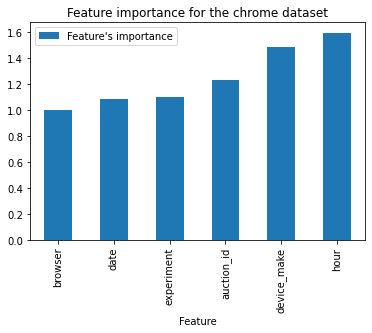

In [58]:
feature_importance_df["Feature"]
feature_importance_df.plot.bar(x='Feature', y="Feature's importance", rot=90)
plt.title('Feature importance for the chrome dataset')